# Pneumonia Detection

In [ ]:
!pip install kaggle
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import shutil
import os

TRAIN_PATH = "/content/drive/MyDrive/tesis/pruebat/prueba/train"
VAL_PATH = "/content/drive/MyDrive/tesis/pruebat/prueba/val"
VAL_SIZE = 0.2

labels = ['BAC_PNEUMONIA', 'NORMAL', 'VIR_PNEUMONIA']
train_bac = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[0])+'/*.jpeg'))
train_normal = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[1])+'/*.jpeg'))
train_viral = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[2])+'/*.jpeg'))

rng = np.random.RandomState(42)
rng.shuffle(train_bac)
rng.shuffle(train_normal)
rng.shuffle(train_viral)

for i, train_files in enumerate([train_bac, train_normal, train_viral]):
  val_split = int(len(train_files)*VAL_SIZE)
  train_files = train_files[:val_split]
  for train_file in train_files:
    file_path = os.path.join(VAL_PATH, labels[i])
    shutil.move(train_file, file_path)


## Image Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generate_image():
    TRAINING_DIR = "/content/drive/MyDrive/tesis/pruebat/prueba/train"
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        height_shift_range=0.2,
        width_shift_range=0.2,
        fill_mode="nearest",
        horizontal_flip=True,
        vertical_flip=True,
    )

    train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(224, 224),
        batch_size=64,
        class_mode="categorical",
        color_mode='rgb',
    )

    VALIDATION_DIR = "/content/drive/MyDrive/tesis/pruebat/prueba/val"
    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(224, 224),
        batch_size=16,
        class_mode="categorical",
        color_mode='rgb',
    )

    return train_generator, validation_generator


In [ ]:
generate_image()[0].class_indices

Found 153 images belonging to 3 classes.
Found 3995 images belonging to 3 classes.


{'BAC_PNEUMONIA': 0, 'NORMAL': 1, 'VIR_PNEUMONIA': 2}

## Modeling with CNN

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def nn():
    inputs = Input(shape=(224, 224, 3))

    x = Conv2D(32, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    outputs = Dense(3, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model


In [ ]:
import tensorflow as tf
import tensorflow as keras
from tensorflow.keras.optimizers import Adam

model = nn()

optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
             metrics=[keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall'),
                        keras.metrics.AUC(name='auc'),
                        keras.metrics.CategoricalAccuracy(name='acc')])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,240,163 (12.36 MB)

 Trainable params: 3,240,163 (12.36 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self,
               desired_acc=0.5):
    self.desired_acc = desired_acc

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>self.desired_acc):
      print(f"\nReached {self.desired_acc} accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
import tensorflow as tf
import tensorflow as keras
from tensorflow.keras.optimizers import Adam

train_generator, validation_generator = generate_image()

callbacks = myCallback(0.80)
history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Found 153 images belonging to 3 classes.
Found 3995 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 180s 82s/step - acc: 0.4042 - auc: 0.5450 - loss: 1.6369 - precision: 0.2482 - recall: 0.1214 - val_acc: 0.3337 - val_auc: 0.5173 - val_loss: 1.8759 - val_precision: 0.3337 - val_recall: 0.3337
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 150s 73s/step - acc: 0.3879 - auc: 0.5360 - loss: 1.6692 - precision: 0.3866 - recall: 0.3050 - val_acc: 0.3342 - val_auc: 0.5461 - val_loss: 1.0935 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 147s 69s/step - acc: 0.3033 - auc: 0.5331 - loss: 1.1008 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_acc: 0.3327 - val_auc: 0.5770 - val_loss: 1.0938 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 145s 70s/step - acc: 0.2860 - auc: 0.4920 - loss: 1.1100 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_acc: 0.3327 - val_auc: 0.6183 - val_loss: 1.0892 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 151s

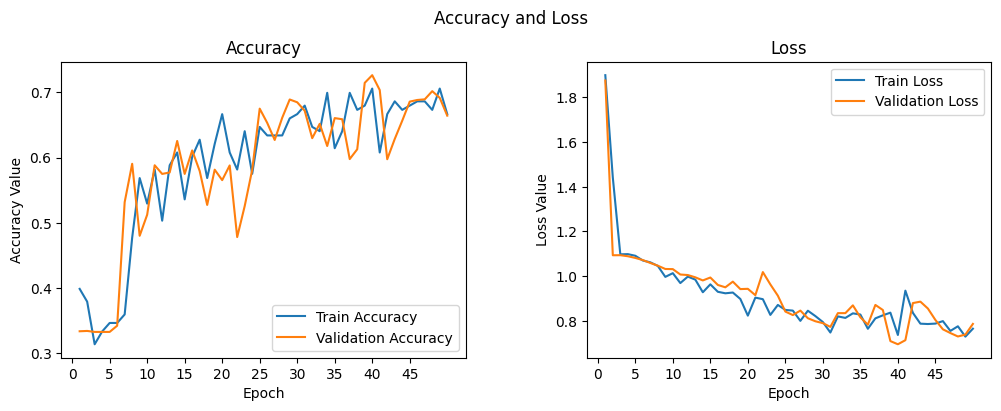

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Accuracy and Loss', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = 50
epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Plot Confusion Matrix

In [ ]:
TEST_DIR = "/content/drive/MyDrive/tesis/pruebat/prueba/test"
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size= 1,
    class_mode="categorical",
    color_mode='rgb',
    shuffle = False,
)

Found 300 images belonging to 3 classes.


In [ ]:
import numpy as np

filenames = test_generator.filenames
nb_samples = len(filenames)

predictions = model.predict(test_generator, steps = nb_samples)
y_pred = np.rint(predictions)
y_pred = tf.argmax(y_pred, axis=1)

y_true = test_generator.classes

300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step


In [ ]:
y_pred

<tf.Tensor: shape=(300,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 2, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0,
       0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2,
     

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], d

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=60)
    plt.yticks(tick_marks, classes, fontsize=60)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=60)

    plt.ylabel('True label', fontsize=60)
    plt.xlabel('Predicted label', fontsize=60)

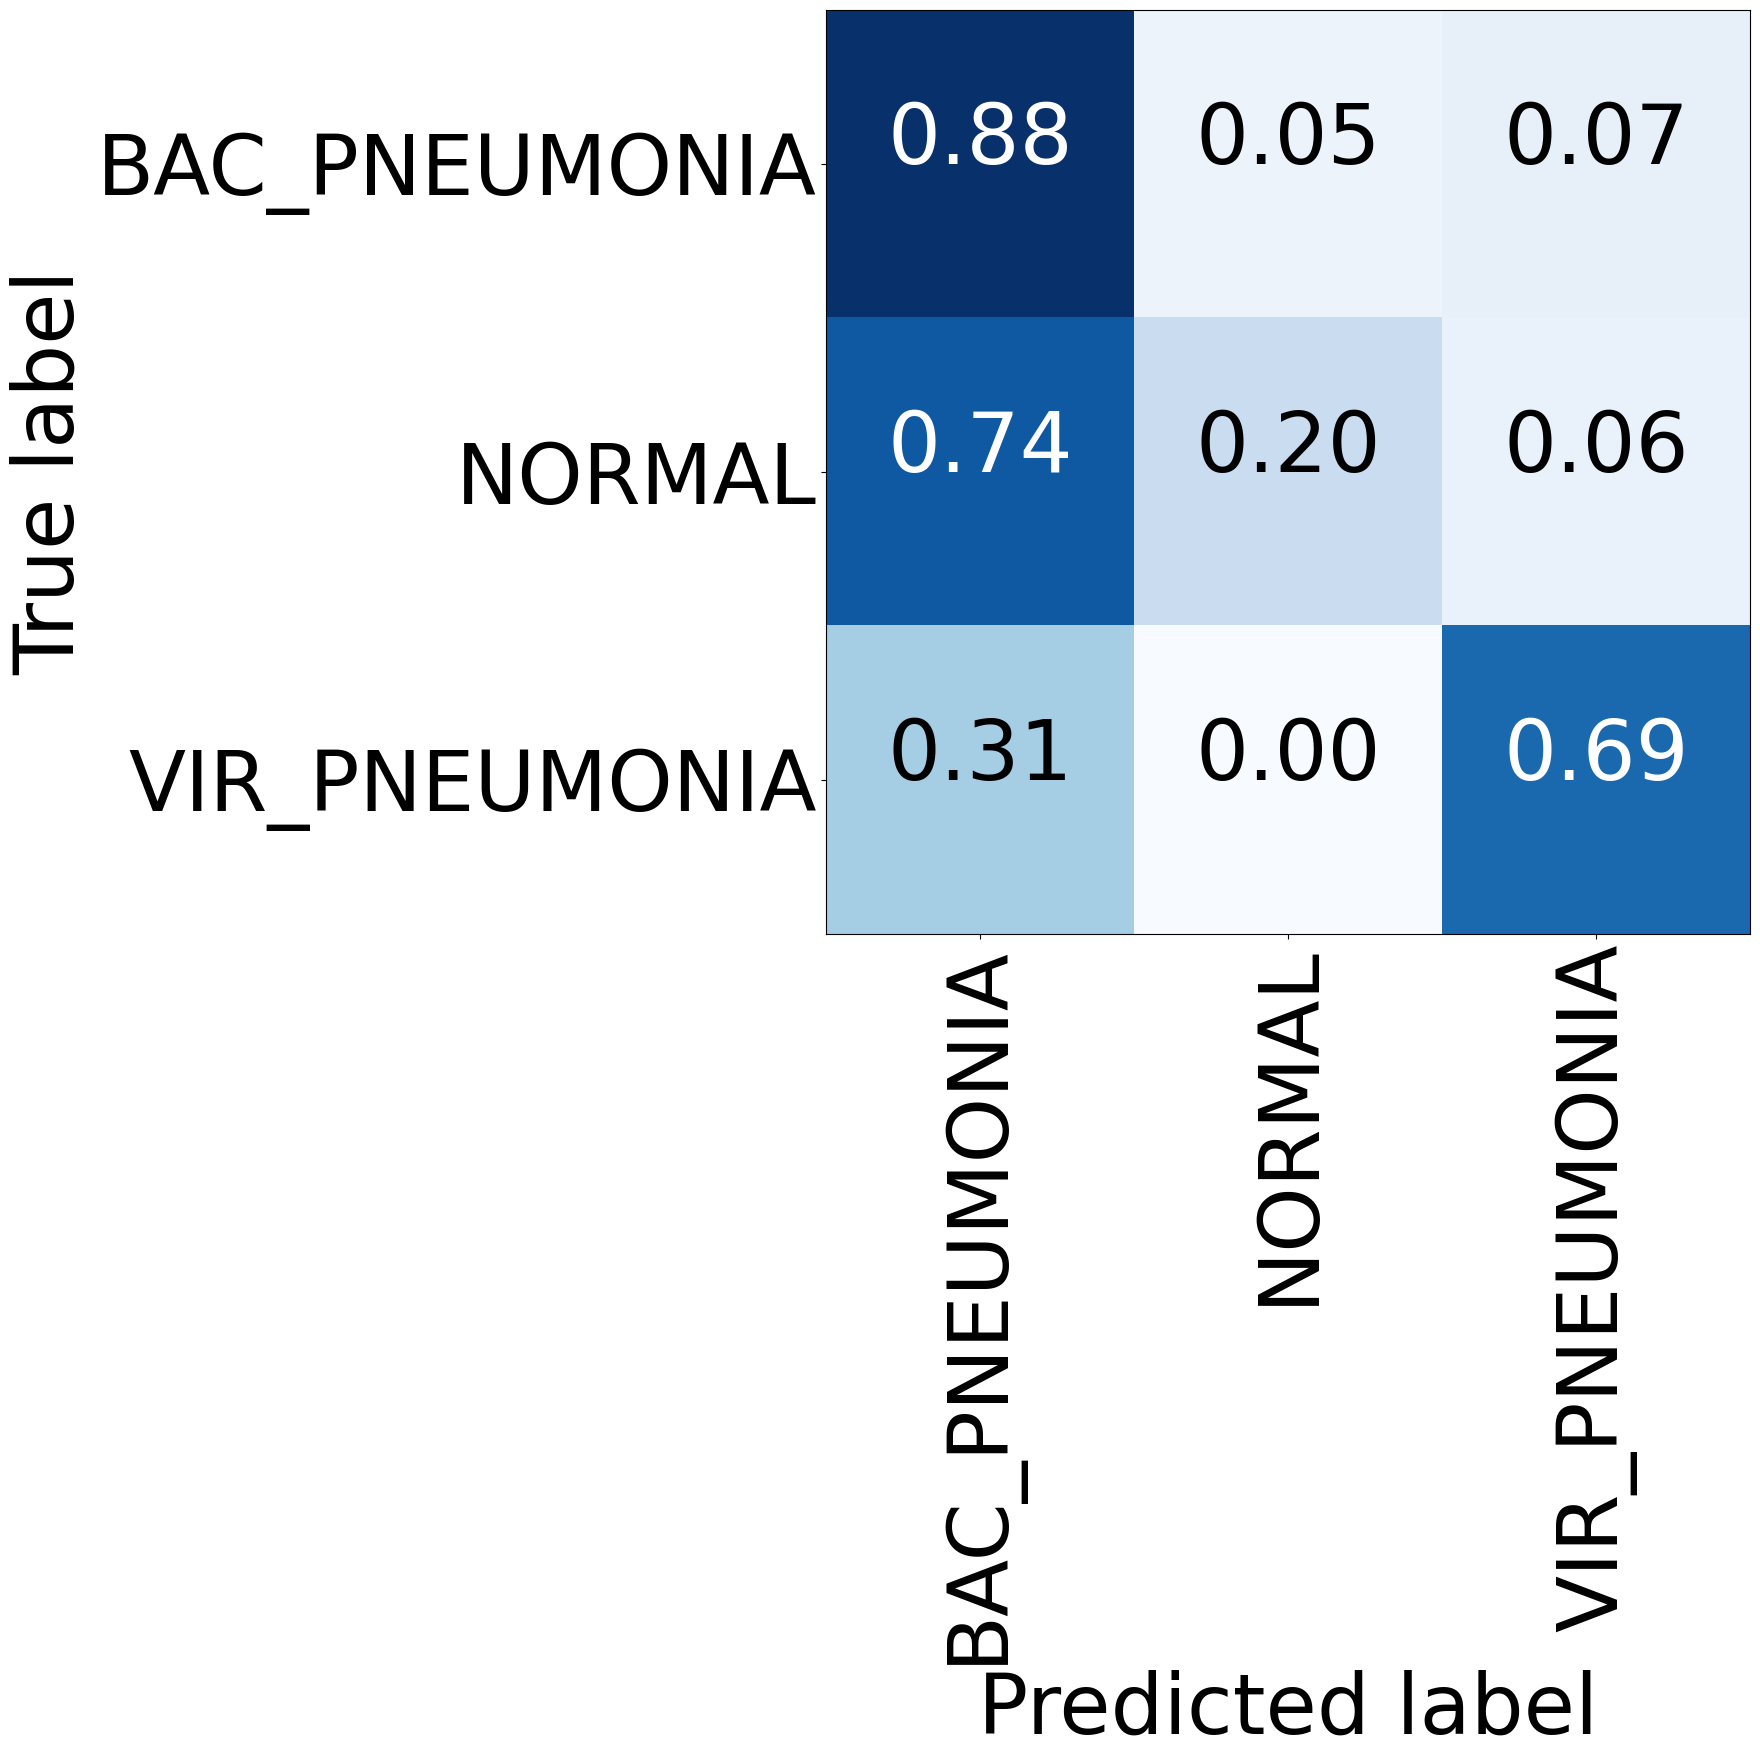

In [ ]:
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=validation_generator.class_indices.keys(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.46      0.88      0.60       100
           1       0.80      0.20      0.32       100
           2       0.84      0.69      0.76       100

    accuracy                           0.59       300
   macro avg       0.70      0.59      0.56       300
weighted avg       0.70      0.59      0.56       300



In [ ]:
model.evaluate(test_generator)

300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - acc: 0.6919 - auc: 0.8056 - loss: 0.8442 - precision: 0.7790 - recall: 0.6509


[0.8681617975234985,
 0.739130437374115,
 0.5666666626930237,
 0.7993166446685791,
 0.6499999761581421]

## Save Model

In [ ]:
model.save("CNN.keras")